In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

np.random.seed(42)

df_train = pd.read_csv("PhiTrain.csv", index_col=0) # shape: (56, 200) / k=55 & y_T => 56 rows
df_valid = pd.read_csv("PhiValid.csv", index_col=0) # shape: (56, 1476) / k=55 & y_T => 56 rows

n_rows = df_train.shape[0] - 1 # 55 / excluding y_T
p_train = df_train.shape[1] # 200
p_valid = df_valid.shape[1] # 1476

y_T = np.array(df_train.iloc[-1,:]).reshape(1, p_train) # shape: (1, 200)
y_T_v = np.array(df_valid.iloc[-1,:]).reshape(1, p_valid) # shape: (1, 1476)

input = np.array(df_train.iloc[:-1, :]) # shape: (55, 200) / excluding y_T_train
input_v = np.array(df_valid.iloc[:-1, :]) # shape: (55, 1476) / excluding y_T_valid

power_set = np.linspace(-4,4,81)
coef_set = 10 ** power_set
I = np.identity(n_rows) # shape: (55, 55)

def train(coef_set, input, I, y_T):

    mse_min = np.inf # to get first mse as a minimal mse
    mse_mean_total = []
    mse_std_total = []
    
    for coef in coef_set:
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_list = []
        
        for train_index, test_index in kf.split(input.T): # KFold splits rows in general => transpose input
            input_train, input_test = input[:, train_index], input[:, test_index] # shape: (55, 180), (55, 20) / (55, 1328), (55, 148)
            y_train, y_test = y_T[:, train_index], y_T[:, test_index] # shape: (1, 180), (1, 20) / (1, 1328), (1, 148)
            w = np.linalg.solve(input_train @ input_train.T + coef * I, input_train @ y_train.T) # shape: (55, 1)
            # predict the outputs for the test set
            y_pred = w.T @ input_test # shape: (1, 20) / (1, 148)
    
            mse = mean_squared_error(y_test.T, y_pred.T)
            mse_list.append(mse)
    
        mse_mean = np.mean(mse_list)
        mse_std = np.std(mse_list)
        mse_mean_total.append(mse_mean)
        mse_std_total.append(mse_std)
    
        if mse_mean < mse_min:
            mse_min = mse_mean
            coef_opt = coef

    return mse_min, coef_opt, mse_mean_total, mse_std_total

mse_min, coef_opt, mse_mean_total, mse_std_total = train(coef_set=coef_set, input=input, I=I, y_T=y_T)
    
# (a) (ii) 
print(f"The minimal average MSE over all test folds: {mse_min:.3f}")
print(f"Best regularization coefficient: {coef_opt:.3f}")
print(f"Best regularization coefficient in log: {np.log(coef_opt):.3f}")

The minimal average MSE over all test folds: 57.291
Best regularization coefficient: 10.000
Best regularization coefficient in log: 2.303


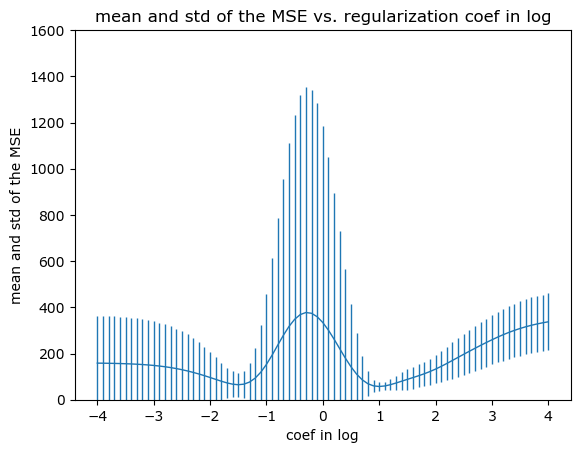

In [2]:
# (a) (i) Plot the average and standard deviation of the MSE vs. coef (logarithmic x-axis)

log_coef_set = np.log10(coef_set)

def plot_errorbar(x, y, err, ymax, title, xlabel, ylabel):
    plt.errorbar(x, y, err, linewidth=1)
    plt.title(title)
    plt.ylim([0, ymax])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

title = 'mean and std of the MSE vs. regularization coef in log'
xlabel = 'coef in log'
ylabel = 'mean and std of the MSE'
ymax = 1600

plot_errorbar(log_coef_set, mse_mean_total, mse_std_total, ymax=ymax, title=title, xlabel=xlabel, ylabel=ylabel)

Bias of validation set: -0.774
Variance of error: 30.289

MSE of the model on the validation set: 30.887



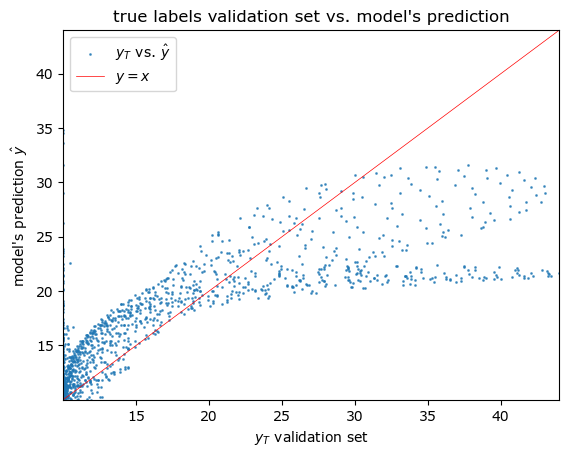

In [15]:
# (a) (iii)

w_opt = np.linalg.solve(input @ input.T + coef_opt * I, input @ y_T.T) # shape: (55, 1)
y_pred_v = w_opt.T @ input_v # shape: (1, 1476)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
bias = np.mean(y_pred_v - y_T_v)
print(f"Bias of validation set: {bias:.3f}")
err_var = np.var(y_pred_v - y_T_v)
print(f"Variance of error: {err_var:.3f}\n")

mse_v = mean_squared_error(y_pred_v, y_T_v)
print(f"MSE of the model on the validation set: {mse_v:.3f}\n")
# MSE too large
# model fits the training set well, but generalizes poorly to unseen data
# possible causes:
# regularization coefficient too small
# cross-validation split is unstable
# too few training samples (200)
# high-dimensional feature space (55 monomials)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
x_min = min(y_T_v.flatten())
x_max = max(y_T_v.flatten())

plt.scatter(y_T_v, y_pred_v, s=1, alpha=0.7, label='$y_T$ vs. $\hat{y}$')
plt.plot([x_min, x_max], [x_min, x_max], color='red', linewidth=0.5, label='$y=x$')
plt.title("true labels validation set vs. model's prediction")
plt.xlabel('$y_T$ validation set')
plt.ylabel("model's prediction $\hat{y}$")
plt.xlim([x_min, x_max])
plt.ylim([x_min, x_max])
plt.legend()
plt.show()

# points above the line: overfitting, overestimate
# points under the line: underfitting, underestimate

The minimal average MSE over all test folds for validation set: 1.954
Best regularization coefficient for validation set: 0.040
Best regularization coefficient in log: -3.224



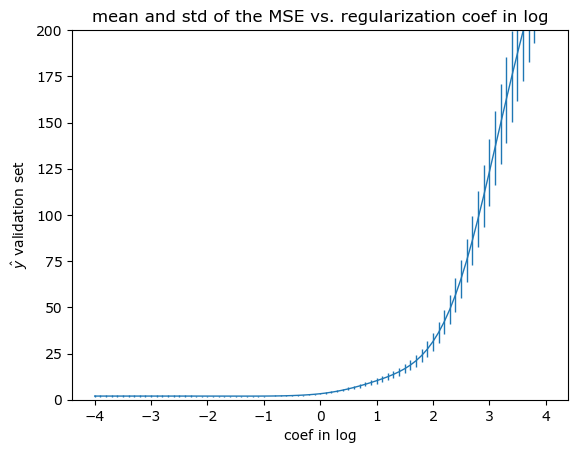

In [4]:
# (b)

mse_v_min, coef_G_opt, mse_v_mean_total, mse_v_std_total = train(coef_set=coef_set, input=input_v, I=I, y_T=y_T_v)

print(f"The minimal average MSE over all test folds for validation set: {mse_v_min:.3f}")
print(f"Best regularization coefficient for validation set: {coef_G_opt:.3f}")
print(f"Best regularization coefficient in log: {np.log(coef_G_opt):.3f}\n")

title_v = title
xlabel_v = xlabel
ylabel_v = '$\hat{y}$ validation set'
ymax_v = 200

plot_errorbar(log_coef_set, mse_v_mean_total, mse_v_std_total, ymax=ymax_v, title=title_v, xlabel=xlabel_v, ylabel=ylabel_v)

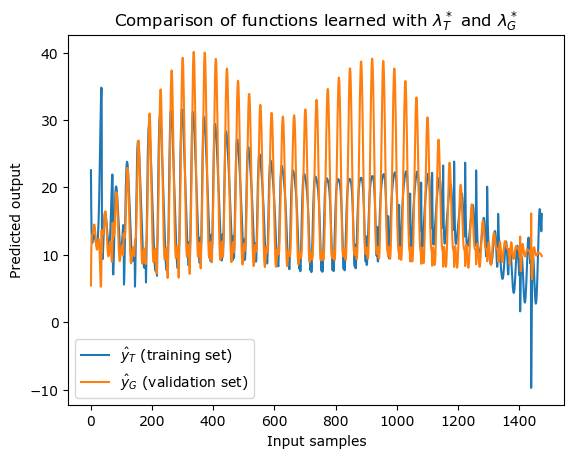

Two lambdas (training & validation set) are similar but different since they base on different data


In [8]:
# (c)
# evaluate both models on the same grid (validation set)
# to show how well it generalizes to unseen data

# already computed for (a) (iii)
# w_opt = np.linalg.solve(input @ input.T + coef_opt * I, input @ y_T.T) # shape: (55, 1)
# y_pred_v = w_opt.T @ input_v # shape: (1, 1476)

w_opt_G = np.linalg.solve(input_v @ input_v.T + coef_G_opt * I, input_v @ y_T_v.T)
y_pred_G = w_opt_G.T @ input_v

# input samples for x-axis
plt.plot(y_pred_v.flatten(), label='$\hat{y}_T$ (training set)')
plt.plot(y_pred_G.flatten(), label='$\hat{y}_G$ (validation set)')
plt.title("Comparison of functions learned with $\lambda^*_T$ and $\lambda^*_G$")
plt.xlabel('Input samples')
plt.ylabel('Predicted output')
plt.legend()
plt.show()

print('Two lambdas (training & validation set) are similar but different since they base on different data')